# LA Metro Bike Share Optimization - Part 2

With additional demand information, we seek to create a simple quadratic optimization model in Python.

## Optimization models

As seen from competitors, there are multiple ways in which the pricing scheme can be structured. Some options that we could implement and compare are as follows:
1. Variable rate by minute
2. Variable rate by time intervals (30 minutes for LA Metro currently)
3. Fixed fee for any ride
4. Fixed fee for a time interval before implementing a variable rate
5. Weekly, monthly passes that cover all rides up to a particular duration. Variable rate thereafter

We will examine the current model by LA metro and whether the current level of customer segmentation is necessary. To benchmark the pricing against other operators of bikes and scooters, let's plot out the different pricing curves for all operators.

In [6]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

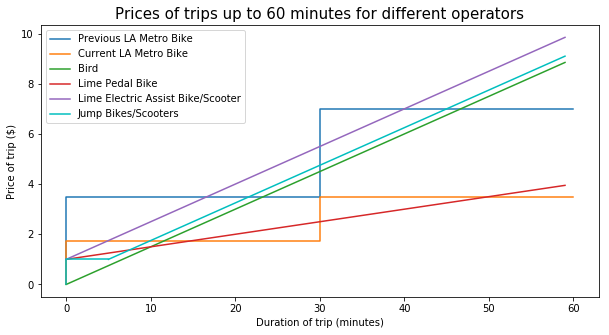

In [7]:
fig, axes = plt.subplots(figsize=(10,5))
x = np.array(range(0,60))
prev_la, = plt.step([0,30,60], [0,3.5,7], label = 'Previous LA Metro Bike')
cur_la, = plt.step([0,30,60], [0,1.75,3.5], label = 'Current LA Metro Bike')
bird, = plt.plot(x, 0.15 * x, label = 'Bird')
lime_ped, = plt.plot(x, 1 + 0.05 * x, label = 'Lime Pedal Bike')
lime_scoot, = plt.plot(x, 1 + 0.15 * x, label = 'Lime Electric Assist Bike/Scooter')
jump1, = plt.step([0,5],[0,1],label = 'Jump Bikes/Scooters',color = 'c')
jump2, = plt.plot(np.array(range(5,60)), 0.15 * np.array(range(5,60)) + 0.25, color = 'c')
plt.title('Prices of trips up to 60 minutes for different operators', size=15)
plt.xlabel('Duration of trip (minutes)')
plt.ylabel('Price of trip ($)')
plt.legend()
plt.show()

Looking at the different pricing schemes across bike and scooter operators in LA, the current pricing that was just enacted by LA Metro is definitely the cheapest, coming in at $3.50 for an hour long bike ride.

The previous pricing for an hour long bike ride for a walk-on was $7, twice the current price.

The next cheapest option is the Lime pedal bike, which is cheaper than walk on riders on LA metro for rides shorter than 15 minutes and for rides between 30 and 50 minutes. 

We will thus formulate the following linear constraints to optimize total revenue for the current pricing structure:   
1. The variable rate per minute without a pass is set under the average of the two most common prices of \$0.05 and \$0.15:    
Variable rate per minute without pass <= \$0.10
2. The variable rate per minute with a plan is set under the average of the LA Metro's current ~\$0.06 and Jump's \$0.07:   
Variable rate per minute with pass <= \$0.065 
3. The variable rate is set under the nearest competitor(Lime pedal):   
Variable rate per 30 minutes <= \$2.5
4. As there aren't many operators out there with comparable pass pricing plans, we maintain the current prices of 5, 17, and 150 for daily pass, monthly pass, and annual pass respectively:      
Daily pass price <= \$5   
Monthly pass price <= \$17   
Annual pass price <= \$150

In [14]:
# Retrieves cleaned dataframe from part 1 of analysis

%store -r

In [15]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,start_hour,active_6m,annual,monthly,one_day,walk_up,one_way,round_trip,time_block_count,time_block_count_post_free
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,...,0,1,0,0,0,1,0,1,2,1
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,...,0,1,0,0,0,1,1,0,1,0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,...,0,1,0,0,0,1,0,1,2,1
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,...,0,1,0,0,0,1,0,1,2,1
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,...,0,1,0,0,0,1,1,0,1,0


In [16]:
agg_pass_groups

,total_trips,pay_count_walk_up,total_30min_blocks,total_30min_blocks_post_free,total_minutes,passes_sold,previous_pass_prices,new_pass_prices,average_charged_blocks_per_ride,percent_total_trips
passholder_type,,,,,,,,,,
annual,9175,0.0,10858,1683,143708,287,40,40,0.183433,0.036625
monthly,146531,0.0,165592,19061,1982585,18317,20,17,0.130082,0.584924
daily,14640,0.0,38517,23877,937578,5229,7,5,1.630943,0.058440
walk_up,80167,80167.0,178895,98728,4158810,0,0,0,1.231529,0.320011


## Quadratic Optimization

Judging from the above linear optimization results, we keep the daily and monthly plans in our pricing scheme. We will also replace the previous annual (Flex) plan with the new plan costing $150 per annum.

We now move on to quadratic optimization for two main factors: price and number of rides. If we had simply run a linear optimization with an upper bound for price, the model would intuitively move towards the upper bound for our optimization problem.

We would thus need to factor in a demand curve that would vary total rides taken along with the price charged for each half hour block.

## Demand curve estimation

It was during the end of this write-up that 2018 Q3 figures were released for LA Metro Bikes. It might just be an additional data point but we can now fit a rudimentary linear demand curve for model constraints to allow price and demand to fluctuate.

2018 Q2 was the last datapoint before the price change and 2018 Q3 was the first after. We set y as price for every 30 minute ride and x as the total number of rides in that quarter.

In [17]:
x1 = 77357
x2 = 95283
y1 = 3.5
y2 = 1.75

slope = (y2-y1)/(x2-x1)
intercept = y2 - x2 * slope

def print_func(slope, intercept):
    print('The linear function from two data points is: y =',slope,'x +',intercept)
    print('Where y = price for half hour block\n      x = rides in fiscal quarter')

print_func(slope, intercept)

The linear function from two data points is: y = -9.762356353899364e-05 x + 11.05186600468593
Where y = price for half hour block
      x = rides in fiscal quarter


### Demand curves by customer segments

What if we broke down demand by customer segments?

We start by creating grouped tables across 2018 Q2 and 2018 Q3.

In [18]:
new_data = pd.read_csv('../data/external/2018Q3.csv')
old_data = pd.read_csv('../data/external/2018Q2.csv')

new_riders = new_data.groupby('passholder_type').agg({
    'trip_id' : 'count',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id':'total_trips',
    'duration':'total_minutes'
})


old_riders= old_data.groupby('passholder_type').agg({
    'trip_id' : 'count',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id':'total_trips',
    'duration':'total_minutes'
})

old_riders['percent_total_trips'] = old_riders['total_trips']/sum(old_riders['total_trips'])

new_riders['percent_total_trips'] = new_riders['total_trips']/sum(new_riders['total_trips'])

old_riders

,total_trips,total_minutes,percent_total_trips
passholder_type,,,
Flex Pass,2420,44561,0.031284
Monthly Pass,44032,746889,0.569205
One Day Pass,5020,354571,0.064894
Walk-up,25885,1699647,0.334617


In [19]:
new_riders

,total_trips,total_minutes,percent_total_trips
passholder_type,,,
Annual Pass,12,1459,0.000126
Flex Pass,1577,31684,0.016551
Monthly Pass,43967,883475,0.461436
One Day Pass,4737,361091,0.049715
Walk-up,44990,3326240,0.472172


We can see the new annual pass hasn't quite caught on yet, with only 12 passes sold in the pass quarter. The $150 price point might be a little steep up front. 

It is also interesting to note how the price drop hasn't really impacted any of the pass holders but has almost doubled the number of walk-up riders.

Let's see what the other demand curves look like.

In [21]:
slope_walk_up = (1.75-3.5) / (new_riders['total_trips']['Walk-up']-old_riders['total_trips']['Walk-up'])
slope_daily = (1.75-3.5) / (new_riders['total_trips']['One Day Pass']-old_riders['total_trips']['One Day Pass'])
slope_monthly = (1.75-3.5) / (new_riders['total_trips']['Monthly Pass']-old_riders['total_trips']['Monthly Pass'])
slope_annual = (1.75-3.5) / (new_riders['total_trips']['Flex Pass']-old_riders['total_trips']['Flex Pass'])

intercept_walk_up = 1.75 - new_riders['total_trips']['Walk-up'] * slope_walk_up
intercept_daily = 1.75 - new_riders['total_trips']['One Day Pass'] * slope_daily
intercept_monthly = 1.75 - new_riders['total_trips']['Monthly Pass'] * slope_monthly
intercept_annual = 1.75 - new_riders['total_trips']['Flex Pass'] * slope_annual

print('Walk up demand function estimate')
print_func(slope_walk_up, intercept_walk_up)   
print('\n')
print('Daily pass demand function estimate')
print_func(slope_daily, intercept_daily)   
print('\n')
print('Monthly pass demand function estimate')
print_func(slope_monthly, intercept_monthly)
print('\n')
print('Annual(Flex) pass demand function estimate')
print_func(slope_annual, intercept_annual)

Walk up demand function estimate
The linear function from two data points is: y = -9.159905783826223e-05 x + 5.871041612143418
Where y = price for half hour block
      x = rides in fiscal quarter


Daily pass demand function estimate
The linear function from two data points is: y = 0.006183745583038869 x + -27.542402826855124
Where y = price for half hour block
      x = rides in fiscal quarter


Monthly pass demand function estimate
The linear function from two data points is: y = 0.026923076923076925 x + -1181.9769230769232
Where y = price for half hour block
      x = rides in fiscal quarter


Annual(Flex) pass demand function estimate
The linear function from two data points is: y = 0.0020759193357058124 x + -1.5237247924080664
Where y = price for half hour block
      x = rides in fiscal quarter


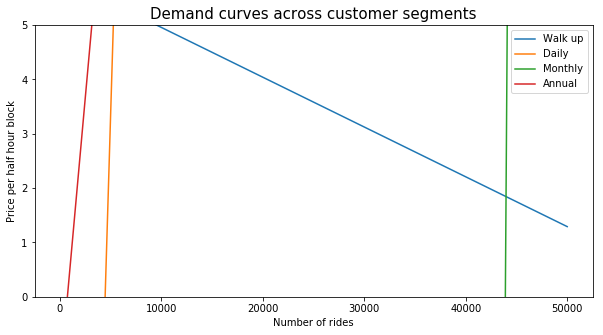

In [22]:
def walk_up_demand(x):
    return slope_walk_up * x + intercept_walk_up

def daily_demand(x):
    return slope_daily * x + intercept_daily

def monthly_demand(x):
    return slope_monthly * x + intercept_monthly

def annual_demand(x):
    return slope_annual * x + intercept_annual

q = np.linspace(0,50000)
fig, axes = plt.subplots(figsize=(10,5))
plt.plot(q, walk_up_demand(q), label = 'Walk up')
plt.plot(q, daily_demand(q), label = 'Daily')
plt.plot(q, monthly_demand(q), label = 'Monthly')
plt.plot(q, annual_demand(q), label = 'Annual')
plt.title('Demand curves across customer segments', size=15)
plt.xlabel('Number of rides')
plt.ylabel('Price per half hour block')
plt.ylim(0,5)
plt.legend()

## Optimization with Scipy Optimize

In [24]:
# Constants

daily_pass = agg_pass_groups['new_pass_prices']['daily']
monthly_pass = agg_pass_groups['new_pass_prices']['monthly']
annual_pass = 150

walk_up_share = agg_pass_groups['percent_total_trips']['walk_up']
daily_share = agg_pass_groups['percent_total_trips']['daily']
monthly_share = agg_pass_groups['percent_total_trips']['monthly']
annual_share = agg_pass_groups['percent_total_trips']['annual']

walk_up_charged_blocks = agg_pass_groups['average_charged_blocks_per_ride']['walk_up']
daily_charged_blocks = agg_pass_groups['average_charged_blocks_per_ride']['daily']
monthly_charged_blocks = agg_pass_groups['average_charged_blocks_per_ride']['monthly']
annual_charged_blocks = agg_pass_groups['average_charged_blocks_per_ride']['annual']

In [44]:
from scipy.optimize import minimize

# Base quadratic with demand curve.

def objective(x):
    rate = x[0]
    riders = x[1]
    
    walk_up_rev = riders * walk_up_share * walk_up_charged_blocks * rate
    day_rev = riders * daily_share * daily_charged_blocks * rate
    month_rev = riders * monthly_share * monthly_charged_blocks * rate
    annual_rev = riders * annual_share * annual_charged_blocks * rate
    
    day_pass_rev = riders * daily_share * daily_pass
    month_pass_rev = riders * monthly_share * monthly_pass
    annual_pass_rev = riders * annual_share * annual_pass
    
    total_revenue = walk_up_rev + day_rev + month_rev + annual_rev + day_pass_rev + month_pass_rev + annual_pass_rev
    return -total_revenue

def demand_constraint(x):
    rate = x[0]
    riders = x[1]
    return rate - slope * riders - intercept

cons = {'type':'eq', 'fun':demand_constraint}
    
b1 = (1.5, 2.5)
b2 = (50000, 140000)

bnds = (b1,b2)

x0 = np.array([1.75, 77357])

sol = minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds)

print(sol)
print(-round(sol['fun']))

     fun: -1623030.3308773183
     jac: array([-5.59883906e+04, -1.65781250e+01])
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([1.50000000e+00, 9.78438571e+04])
1623030


In [49]:
price_range_1 = (1, 2.5)
price_range_2 = (1.25, 2.5)
price_range_3 = (1.5, 2.5)
price_range_4 = (1.75, 2.5)

rider_range_1 = (50000, 80000)
rider_range_2 = (50000, 100000)
rider_range_3 = (50000, 120000)
rider_range_4 = (50000, 140000)

bounds = [((price_range_1, rider_range_1)) , ((price_range_1, rider_range_2)) , ((price_range_1, rider_range_3))
          , ((price_range_1, rider_range_4)) , ((price_range_2, rider_range_1)) , ((price_range_2, rider_range_2))
          , ((price_range_2, rider_range_3)) , ((price_range_2, rider_range_4)) , ((price_range_3, rider_range_1))
          , ((price_range_3, rider_range_2)) , ((price_range_3, rider_range_3)) , ((price_range_3, rider_range_4))
          , ((price_range_4, rider_range_1)) , ((price_range_4, rider_range_2)) , ((price_range_4, rider_range_3))
          , ((price_range_4, rider_range_4))
          ]

sensitivity_results = [minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds) for bnds in bounds]
sensitivity_total_rev = [-round(sol['fun']) for sol in sensitivity_results]
sensitivity_rate = [round(sol['x'][0]) for sol in sensitivity_results]
sensitivity_riders = [round(sol['x'][1]) for sol in sensitivity_results]
price_ranges = [pair[0] for pair in bounds]
rider_ranges = [pair[1] for pair in bounds]

sensitivity_sorted = sorted(list(zip(sensitivity_total_rev, sensitivity_rate, sensitivity_riders, price_ranges, 
                                     rider_ranges)), reverse = True)

print('Total rev | Rate | Total riders | Rate range | Rider range')
for test_i in range(len(sensitivity_sorted)):
    print(sensitivity_sorted[test_i][0], '   ',sensitivity_sorted[test_i][1], '  ',
          sensitivity_sorted[test_i][2], 
          '     ',sensitivity_sorted[test_i][3], '   ', sensitivity_sorted[test_i][4])

Total rev | Rate | Total riders | Rate range | Rider range
1678530     1.0    102966.0       (1, 2.5)     (50000, 140000)
1678530     1.0    102966.0       (1, 2.5)     (50000, 120000)
1651146     1.0    100405.0       (1.25, 2.5)     (50000, 140000)
1651146     1.0    100405.0       (1.25, 2.5)     (50000, 120000)
1646752     1.0    100000.0       (1.25, 2.5)     (50000, 100000)
1646752     1.0    100000.0       (1, 2.5)     (50000, 100000)
1623030     2.0    97844.0       (1.5, 2.5)     (50000, 140000)
1623030     2.0    97844.0       (1.5, 2.5)     (50000, 120000)
1623030     2.0    97844.0       (1.5, 2.5)     (50000, 100000)
1594182     2.0    95283.0       (1.75, 2.5)     (50000, 140000)
1594182     2.0    95283.0       (1.75, 2.5)     (50000, 120000)
1594182     2.0    95283.0       (1.75, 2.5)     (50000, 100000)
1372815     2.0    80000.0       (1.75, 2.5)     (50000, 80000)
1372815     2.0    80000.0       (1.5, 2.5)     (50000, 80000)
1372815     2.0    80000.0       (1.25, 

In [41]:
# Incorporating segmented demand curves

def objective(x):
    walk_rate = x[0]
    walk_riders = x[1]
    day_rate = x[2]
    day_riders = x[3]
    month_rate = x[4]
    month_riders = x[5]
    
#     annual_rate = x[6]
    
    walk_up_rev = walk_riders * walk_up_charged_blocks * walk_rate
    day_rev = day_riders * daily_charged_blocks * day_rate
    month_rev = month_riders * monthly_charged_blocks * month_rate
    
#     annual_riders = (walk_riders + day_riders + month_riders)*(annual_share_new/(walk_up_share_new + daily_share_new
#                                                                                  + monthly_share_new))
#     annual_rev = annual_riders * annual_charged_blocks * annual_rate
    
    day_pass_rev = day_riders * daily_pass
    month_pass_rev = month_riders * monthly_pass
#     annual_pass_rev = annual_riders * annual_pass
    
    total_revenue = walk_up_rev + day_rev + month_rev + day_pass_rev + month_pass_rev
    return -total_revenue

def demand_constraint_walk_up(x):
    rate = x[0]
    riders = x[1]
    return rate - slope_walk_up * riders - intercept_walk_up

def demand_constraint_daily(x):
    rate = x[2]
    riders = x[3]
    return rate - slope_daily * riders - intercept_daily

def demand_constraint_monthly(x):
    rate = x[4]
    riders = x[5]
    return rate - slope_monthly * riders - intercept_monthly

cons = {'type':'eq', 'fun':demand_constraint_walk_up,
       'type':'eq', 'fun':demand_constraint_daily,
       'type':'eq', 'fun':demand_constraint_monthly}
    
b1 = (1.5, 2.5)
b2 = (new_riders['total_trips']['Walk-up']/2, new_riders['total_trips']['Walk-up']*2)
b3 = (1.5, 2.5)
b4 = (new_riders['total_trips']['One Day Pass']/2, new_riders['total_trips']['One Day Pass']*2)
b5 = (1.5, 2.5)
b6 = (new_riders['total_trips']['Monthly Pass']/2, new_riders['total_trips']['Monthly Pass']*2)

bnds = (b1,b2,b3,b4,b5,b6)

x0 = np.array([1.75, new_riders['total_trips']['Walk-up'], 1.75, new_riders['total_trips']['One Day Pass']
               , 1.75, new_riders['total_trips']['Monthly Pass']])

sol = minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds)

print(sol)
print(-round(sol['fun']))

     fun: -990906.4025506205
     jac: array([-5.73594219e+04, -3.06250000e+00, -1.54405000e+04, -9.07031250e+00,
       -5.72292188e+03, -1.73281250e+01])
 message: 'Positive directional derivative for linesearch'
    nfev: 56
     nit: 11
    njev: 7
  status: 8
 success: False
       x: array([2.48989629e+00, 4.65757678e+04, 2.49560331e+00, 9.46722294e+03,
       2.49969315e+00, 4.39948458e+04])
990906


In [38]:
-round(sol['fun']) + annual_pass

991056

In [34]:
new_riders

,total_trips,total_minutes,percent_total_trips
passholder_type,,,
Annual Pass,12,1459,0.000126
Flex Pass,1577,31684,0.016551
Monthly Pass,43967,883475,0.461436
One Day Pass,4737,361091,0.049715
Walk-up,44990,3326240,0.472172


In [36]:
annual_pass

150